## Import the Necessary functions


In [147]:
import pandas as pd
import numpy as np
import json
import pprint
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Conv1D, Add, MultiHeadAttention,MultiHeadAttention, Dropout, LayerNormalization,Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import load_model
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import correlate, correlation_lags
from datetime import datetime
import random
from math import inf
import tensorflow as tf


# Define Constants

In [148]:
SUBSTITUTE_VALUE = -1
MAX_CONNECTORS = 10
TIMESTEPS = 144

weather_cols = ['G_0']    #[ 'G_0', 'RH', 'T_a']

# ML model class definition
let's define the class for our ML Molel

In [149]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv1D(filters, kernel_size, padding='same', activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = Conv1D(filters, kernel_size, padding='same', activation=None)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = Conv1D(filters, 1, padding='same')
        self.add = Add()
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # Apply 1x1 convolution to inputs to match the shape
        inputs = self.conv3(inputs)

        x = self.add([x, inputs])
        return self.relu(x)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, sequence_length, d_model):
        angle_rads = self.get_angles(
            position=tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # Apply sin to even indices in the array; 2i
        angle_rads = tf.where(
            tf.range(d_model) % 2 == 0,
            tf.math.sin(angle_rads),
            tf.math.cos(angle_rads)
        )

        pos_encoding = angle_rads[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


class timeseries_ml_model(tf.keras.Model):
  def __init__(self,
               time_steps,
               input_features=48,
               epochs=100,
               batch_size=16,
               save_best_model_during_training=False,
               loss = 'binary_crossentropy',
               metric = 'accuracy',
               optimizer = 'adam',
               last_activation = 'softmax',
               output_size=3,
               dense_neurons = 16
               ):
    self.time_steps = time_steps
    self.input_features = input_features
    self.epochs = epochs
    self.batch_size = batch_size
    self.optimizer = optimizer
    self.last_activation = last_activation
    self.x_train = None
    self.x_test = None
    self.y_train = None
    self.y_test = None
    self.model = None
    self.dl_model = None
    self.dl_model2 = None
    self.dl_model3 = None
    self.model_checkpoints = save_best_model_during_training
    self.loss = loss
    self.metric = metric
    self.output_size = output_size
    self.dense_neurons = dense_neurons

  def create_model(self):
    self.model = Sequential()
    num_of_neurons = self.time_steps * self.input_features
    self.model.add(LSTM(num_of_neurons, input_shape=(self.time_steps, self.input_features)))
    self.model.add(Dense(self.dense_neurons, activation='relu'))
    self.model.add(Dense(self.output_size, activation=self.last_activation))
    self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metric])

  def train_model(self):
    if self.model_checkpoints:
      filepath = 'callback_model.keras'
      model_checkpoint_callback = ModelCheckpoint(filepath,
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='min',
                                                  save_freq='epoch',
                                                  initial_value_threshold=None
                                                  )
      self.model.fit(self.x_train,
                     self.y_train,
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     callbacks=[model_checkpoint_callback])
    else:
      self.model.fit(self.x_train,
                     self.y_train,
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     )

  def get_data(self,
               data,
               target,
               test_split,
               random_state=42):
    (self.x_train,
     self.x_test,
     self.y_train,
     self.y_test) = train_test_split(data,
                                     target,
                                     test_size=test_split,
                                     random_state=random_state)

  def make_predictions(self, model="dl"):
    if model=="dl":
      return self.dl_model3.predict(self.x_test), self.y_test
    else:
      return self.model.predict(self.x_test), self.y_test

  def make_dl_model(self):
    self.dl_model = tf.keras.Sequential([
          tf.keras.layers.Masking(mask_value=SUBSTITUTE_VALUE),
          tf.keras.layers.Normalization(),

          tf.keras.layers.Conv1D(128, 3, activation="relu"),
          tf.keras.layers.MaxPooling1D(),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Conv1D(256, 3, activation="relu"),
          tf.keras.layers.MaxPooling1D(),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),

          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dropout(0.5),

          tf.keras.layers.Dense(3, activation=self.last_activation)
    ])
    self.dl_model.build(input_shape=(None,self.time_steps,self.input_features))
    self.dl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')

  def make_dl_model2(self):
    self.dl_model2 = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=SUBSTITUTE_VALUE),
        tf.keras.layers.Normalization(),


        tf.keras.layers.Reshape((self.time_steps, self.input_features, 1)),

        tf.keras.layers.Conv2D(128, (3, 1), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 1), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=256),

        tf.keras.layers.Reshape((1, 256)),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),

        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(3, activation=self.last_activation)
    ])
    self.dl_model2.build(input_shape=(None,self.time_steps,self.input_features))
    self.dl_model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')



  def make_dl_model3(self):
      inputs = tf.keras.Input(shape=(self.time_steps, self.input_features))
      x = tf.keras.layers.Masking(mask_value=SUBSTITUTE_VALUE)(inputs)
      x = tf.keras.layers.Normalization()(x)

      # Residual blocks with Conv1D
      x = ResidualBlock(128, 3)(x)
      x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
      x = ResidualBlock(256, 3)(x)
      x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.BatchNormalization()(x)

      # Add positional encoding for transformer
      x = PositionalEncoding(self.time_steps // 4, 256)(x)

      # Multi-head attention
      attention_output = MultiHeadAttention(num_heads=8, key_dim=256)(x, x)
      attention_output = Dropout(0.1)(attention_output)
      attention_output = LayerNormalization(epsilon=1e-6)(attention_output + x)

      # Feed-forward layer
      ff_output = Dense(256, activation='relu')(attention_output)
      ff_output = Dropout(0.1)(ff_output)
      ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

      # Bidirectional LSTM layers with LayerNormalization
      x = Bidirectional(LSTM(128, return_sequences=True))(ff_output)
      x = LayerNormalization()(x)
      x = Bidirectional(LSTM(128, return_sequences=True))(x)
      x = LayerNormalization()(x)

      x = GlobalAveragePooling1D()(x)
      x = tf.keras.layers.Dropout(0.5)(x)
      outputs = Dense(3, activation='softmax')(x)  # Assuming regression with 'mse' loss

      self.dl_model3 = tf.keras.Model(inputs, outputs)
      self.dl_model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])


  def train_dl_model(self):
    if self.model_checkpoints:
      filepath = 'callback_model.keras'
      model_checkpoint_callback = ModelCheckpoint(filepath,
                                                  monitor='loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='min',
                                                  save_freq='epoch',
                                                  initial_value_threshold=None
                                                  )
      self.dl_model.fit(self.x_train,
                     self.y_train,
                     epochs=self.epochs,
                     callbacks=[model_checkpoint_callback])
    else:
      self.dl_model.fit(self.x_train,
                     self.y_train,
                     epochs=self.epochs
                     )


  def train_dl_model2(self):
    self.dl_model2.fit(self.x_train,
                     self.y_train,
                     epochs=self.epochs
                     )
  def train_dl_model3(self):
    if self.model_checkpoints:
      filepath = 'callback_model.keras'
      model_checkpoint_callback = ModelCheckpoint(filepath,
                                                  monitor='loss',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='min',
                                                  save_freq='epoch',
                                                  initial_value_threshold=None
      )
      self.dl_model3.fit(self.x_train,
                     self.y_train,
                     epochs=self.epochs,
                     callbacks=[model_checkpoint_callback]
                     )


# Define the helper functions


In [150]:

def calucluate_mean_absolute_error(predictions, actuals):
  # take the absolute difference between the predictions and the labels
  absolute_errors = np.abs(predictions - actuals)
  # calculate the mean absolute error
  mean_absolute_error = np.mean(absolute_errors, axis=0)
  return mean_absolute_error


def get_sensor_data(path, index_column='datetime'):
  data = pd.read_csv(path, index_col=index_column, parse_dates=True)
  date_time = pd.to_datetime(data.index, format='%d.%m.%Y %H:%M:%S')
  day = 24*60*60
  year = (365.2425)*day
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  return data



def fix_lag(all_data, feature1, feature2, lag=None):
  x = all_data[feature1]
  y = all_data[feature2]

  if lag is None:
    correlation = correlate(all_data[feature1], all_data[feature2], mode="full")
    lags = correlation_lags(all_data[feature1].size, all_data[feature2].size, mode="full")
    lag = lags[np.argmax(correlation)]

  if lag < 0:
      x = x.iloc[:lag].reset_index(drop=True)
      x = [np.nan] * abs(lag) + list(x)
  else:
      x = x.iloc[lag:].reset_index(drop=True)
      x = list(x) + [np.nan] * lag
  all_data.loc[:,feature1] = x
  all_data.loc[:,feature2] = y

  return all_data



def get_string_exoskeletons(metadata_path):
  string_1_exoskeltons = []
  string_2_exoskeltons = []

  try:
      with open(metadata_path, 'r') as file:
          metadata = json.load(file)
      print("Metadata file read successfully!")

  except json.JSONDecodeError as err:
      print(f"JSON decode error: {err}")
      print(f"Error at line {err.lineno}, column {err.colno}")
  except Exception as e:
      print(f"An unexpected error occurred: {e}")

  sensor_class = {}
  for sensor, meta in metadata['Sensor_metadata'].items():
    if meta['String_id'] == 'String_1' and meta['sensor_type']=='V_T':
      string_1_exoskeltons.append(sensor)
    elif meta['String_id'] == 'String_2' and meta['sensor_type']=='V_T':
      string_2_exoskeltons.append(sensor)
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_1' and meta['Module_id'] == 'Inverter':
      string_1_inv_sensor = sensor
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_2' and meta['Module_id'] == 'Inverter':
      string_2_inv_sensor = sensor
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_1' and meta['Module_id'] != 'Inverter':
      string_1_current_sensor = sensor
    elif meta['sensor_type'] == 'I' and meta['String_id'] == 'String_2' and meta['Module_id'] != 'Inverter':
      string_2_current_sensor = sensor

    if meta['sensor_type'] == 'V_T':
      sensor_class[sensor] = metadata['MC4_metadata'][meta['MC4_sample_id']]['label']

  return (string_1_exoskeltons,
          string_2_exoskeltons,
          string_1_inv_sensor,
          string_2_inv_sensor,
          string_1_current_sensor,
          string_2_current_sensor,
          metadata)


def append_shifted_inverter_data(input_data,
                                 inverter_data_path,
                                 index_column='datetime',
                                 cols_of_interest=['U_dc_string1',
                                                   'U_dc_string2',
                                                   'I_dc_string1',
                                                   'I_dc_string2']):
  if inverter_data_path != '':
    inv_data = pd.read_csv(inverter_data_path, index_col=index_column, parse_dates=True)
    inv_data = inv_data[cols_of_interest]
    inv_data.index = pd.to_datetime(inv_data.index)
    input_data = pd.merge(input_data, inv_data, on="datetime", how="inner")

  input_data.index = pd.to_datetime(input_data.index)

  d2 = input_data[(input_data.index<='2024-03-29 23:59:59')]
  d3 = input_data[input_data.index>'2024-03-29 23:59:59']

  d2 = fix_lag(d2, 'I_dc_string1', 'I_FEFFFFB71E5E54E1', 13)
  d3 = fix_lag(d3, 'I_dc_string1', 'I_FEFFFFB71E5E54E1', 1)

  d2 = fix_lag(d2, 'I_dc_string2', 'I_FEFFFFB71E5E54E4', 13)
  d3 = fix_lag(d3, 'I_dc_string2', 'I_FEFFFFB71E5E54E4', 1)

  d2 = fix_lag(d2, 'U_dc_string1', 'I_FEFFFFB71E5E54E1', 13)
  d3 = fix_lag(d3, 'U_dc_string1', 'I_FEFFFFB71E5E54E1', 1)

  d2 = fix_lag(d2, 'U_dc_string2', 'I_FEFFFFB71E5E54E4', 13)
  d3 = fix_lag(d3, 'U_dc_string2', 'I_FEFFFFB71E5E54E4', 1)

  return pd.concat([d2,d3], axis=0)


def filter_data(unfiltered_data,
                s1_exos,
                s2_exos,
                s1_current,
                s2_current):
  V_MAX = 0.03
  I_MAX = 10
  G_MIN = 150
  T_MAX = 35
  R_MAX = 0.003

  filtered_data = unfiltered_data.copy()
  voltage_cols = ["V_"+x for x in s1_exos]+["V_"+x for x in s2_exos]
  current_cols = ["I_"+s1_current, "I_"+s2_current]
  temperature_cols = ["T_"+x for x in s1_exos]+["V_"+x for x in s2_exos]
  resistance_cols = ["R_"+x for x in s1_exos]+["R_"+x for x in s2_exos]

  filtered_data[voltage_cols] = filtered_data[voltage_cols].applymap(
      lambda x: x if 0 < x <= V_MAX else np.nan)
  filtered_data[current_cols] = filtered_data[current_cols].applymap(
      lambda x: x if 0 < x <= I_MAX else np.nan)
  filtered_data[temperature_cols] = filtered_data[temperature_cols].applymap(
      lambda x: x if 0 < x <= T_MAX else np.nan)
  filtered_data[resistance_cols] = filtered_data[resistance_cols].applymap(
      lambda x: x if 0 < x <= R_MAX else np.nan)

  filtered_data[['G_0']] = filtered_data[['G_0']].applymap(
      lambda x: x if G_MIN <= x else np.nan)


  return filtered_data

def derive_power_resistance_features( input_data,
                                      _s1_exoskeletons,
                                      _s2_exoskeletons,
                                      _s1_current_sensor,
                                      _s2_current_sensor
                                      ):
  input_data = input_data[(input_data["I_dc_string1"]>0) & (input_data['I_dc_string2']>0)
                          & (input_data["I_"+_s2_current_sensor]>0 ) & (input_data["I_"+_s1_current_sensor]>0)].copy()
  #input_data["V_"+string_1_current_sensor] = input_data[["V_"+x for x in string_1_exoskeltons]].sum(axis=1)
  input_data["P_string1"] = input_data["I_dc_string1"] * input_data["U_dc_string1"]
  input_data["R_string1"] = input_data["U_dc_string1"] / input_data["I_dc_string1"]

  #input_data["V_"+string_2_current_sensor] = input_data[["V_"+x for x in string_2_exoskeltons]].sum(axis=1)
  input_data["P_string2"] = input_data["I_dc_string2"] * input_data["U_dc_string2"]
  input_data["R_string2"] = input_data["U_dc_string2"] / input_data["I_dc_string2"]

  for col in _s1_exoskeletons:
    input_data["P_"+col] = input_data["I_"+_s1_current_sensor] * input_data["V_"+col]
    input_data["R_"+col] = input_data["V_"+col] / input_data["I_"+_s1_current_sensor]

  for col in _s2_exoskeletons:
    input_data["P_"+col] = input_data["I_"+_s2_current_sensor] * input_data["V_"+col]
    input_data["R_"+col] = input_data["V_"+col] / input_data["I_"+_s2_current_sensor]

  # filter the data
  input_data = filter_data(input_data,
                          _s1_exoskeletons,
                          _s2_exoskeletons,
                          _s1_current_sensor,
                          _s2_current_sensor)

  return input_data

def find_missing_days(df):
    missingData = {}
    years = set(df.index.year)
    months = set(df.index.month)
    for year in years:
      missingData[year] = {}
      for month in months:
          absent_days=[]
          try:
            for day in range(min(set(df[(df.index.month==month) & (df.index.year==year)].index.day)),
                            max(set(df[(df.index.month==month) & (df.index.year==year)].index.day))+1):
                if day not in set(df[df.index.month==month].index.day):
                    absent_days.append(day)
          except:
            pass
      missingData[year][month] = absent_days
    return missingData

def prepare_timeseries_data(input_data):
    # calculate all the missing days data
    missingData = find_missing_days(input_data)
    print(missingData)
    # Interpolate at 5 min
    input_data = input_data.resample("5min").interpolate()

    # retain only day time data
    input_data = input_data[(input_data.index.hour>6) & (input_data.index.hour<=18)]
    # remove from the resampled data the days which were not present initially.
    df = input_data.copy()
    for year, missing_days in missingData.items():
      for month, days in missing_days.items():
          for day in days:
              df = df[(df.index.year!=year) | (df.index.month!=month) | (df.index.day!=day)]
    print("New df Len: ",len(df), "Data Len: ",len(input_data))

    # first day and last day might not contain the full day data, so remove them.
    df = df[(df.index.month!=df.index.min().month) | (df.index.day!=df.index.min().day)]
    df = df[(df.index.month!=df.index.max().month) | (df.index.day!=df.index.max().day)]

    return df


def replace_connectors_with_sub_values(input_data, list_of_connectors):
  """
  Parameter:
    input_data: DataFrame, from which the connetors need to be replaced with substiture vales
    list_of_connectors: expects a list of int values in range (0, max_connectors - 1)

  Returns:
    Dataframe, with specified columns replaced with specified subustitute value
  """
  for conn in list_of_connectors:
    conn_cols = [["V_"+x, "T_"+x, "P_"+x, "R_"+x] for x in [conn]]
    for conn in conn_cols[0]:
      if conn in input_data.columns:
        input_data.loc[:,conn] = SUBSTITUTE_VALUE
      else:
        print(conn, " not present in input_data.")
        input_data[conn] = SUBSTITUTE_VALUE
  return input_data


def drop_connectors(input_data, connectors_to_remove):
  """
  This selects a connetor to be dropped from the input_data and appends the
  new input_data to the current its data at the end

  Parameter:
    Data: DataFrame, from which the connetors need to be replaced with substiture vales
    connectors_to_remove: A list of connectors to be removed, where each element is str(connector_number)
  Returns:
    Dataframe, with possible combinations of missing connector appended on the end
  """
  _all_data = input_data.copy()
  for connector_number in sorted(connectors_to_remove, reverse=True):
    input_data = replace_connectors_with_sub_values(input_data, connector_number)
    num_days = len(input_data.resample('1D').mean())
    offset = pd.DateOffset(days=num_days)
    input_data.index = input_data.index + offset

    _all_data = pd.concat([_all_data, input_data], axis=0)

  return _all_data

def fill_substitute(input_data):
  conn_cols = [["V_"+str(x), "T_"+str(x), "P_"+str(x), "R_"+str(x)] for x in range(MAX_CONNECTORS)]
  conn_to_drop = []
  for conn in np.array(conn_cols).flatten():
    if conn not in input_data.columns:
      input_data.loc[:,conn] = SUBSTITUTE_VALUE
    else:
      conn_to_drop.append(conn.split('_')[1])

  _all_data = drop_connectors(input_data, set(conn_to_drop))

  return _all_data

def get_string_data(input_data, _s1_exoskeletons, _s2_exoskeletons):
  s1_vt_cols = [("V_"+x, "T_"+x, "P_"+x, "R_"+x) for x in _s1_exoskeletons]
  inv_cols = ["I_dc_", "U_dc_", "P_", "R_"]
  master_cols = (['Day sin'] +
                weather_cols +
                [x+"string1" for x in inv_cols] +
                [x for vt in s1_vt_cols for x in vt])

  string1_data = input_data[master_cols]
  string1_data = string1_data[np.isfinite(string1_data).all(1)]


  s2_vt_cols = [("V_"+x, "T_"+x, "P_"+x, "R_"+x) for x in _s2_exoskeletons]
  master_cols = (['Day sin'] +
                  weather_cols +
                  [x+"string2" for x in inv_cols] +
                  [x for VT in s2_vt_cols for x in VT])
  string2_data = input_data[master_cols]
  string2_data = string2_data[np.isfinite(string2_data).all(1)]

  new_s1_cols = []
  new_s2_cols = []
  for i, x in enumerate([x for VT in s1_vt_cols for x in VT]):
    new_s1_cols.append(x[:2]+str(int(i/4)))
  new_s1_cols = ['Day sin'] + weather_cols + ["I_S", "V_S", "P_S", "R_S"] + new_s1_cols
  for i, x in enumerate([x for VT in s2_vt_cols for x in VT]):
    new_s2_cols.append(x[:2]+str(int(i/4)))
  new_s2_cols = ['Day sin'] + weather_cols + ["I_S", "V_S", "P_S", "R_S"] + new_s2_cols

  column_mapping_s1 = {}
  column_mapping_s2 = {}
  for col1, col2, col3 in zip(string1_data.columns, string2_data.columns, new_s1_cols):
    column_mapping_s1[col1] = col3
    column_mapping_s2[col1] = col3

  string1_data.columns = new_s1_cols
  string2_data.columns = new_s2_cols

  return string1_data, string2_data, column_mapping_s1, column_mapping_s2


def drop_x_percent_data(input_data, percent, non_substituted_cols, num_permutation, max_connectors, num_days):
  offset = pd.DateOffset(days=num_days)
  input_data.index = input_data.index + offset
  if percent==0:
    return input_data, num_days+len(input_data.resample('1D').mean())

  num_conn_to_drop = int(max_connectors*percent/100)
  _all_data = pd.DataFrame()
  prev_choice = None
  for p in range(num_permutation):
    indices = np.random.choice(max_connectors, num_conn_to_drop, replace=False)
    while (prev_choice==indices).all():
      indices = np.random.choice(max_connectors, num_conn_to_drop, replace=False)

    connectors_to_remove = [non_substituted_cols[i] for i in indices]
    temp_data = replace_connectors_with_sub_values(input_data, connectors_to_remove)
    if len(_all_data)>0:
      num_days = len(_all_data.resample('1D').mean())
      offset = pd.DateOffset(days=num_days)
      temp_data.index = temp_data.index + offset
    _all_data = pd.concat([_all_data, temp_data], axis=0)
    prev_choice = indices

  next_lot_index_starts_after = num_days+len(_all_data.resample('1D').mean())
  return _all_data, next_lot_index_starts_after

def IQR_outliers_filter(input_data, cols):
  for col in cols:
    Q1 = input_data[col].quantile(0.25)
    Q3 = input_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = [x for x in input_data[col] if x < lower_bound or x > upper_bound]
    print(f"IQR outliers in {col}: {outliers}")
    input_data[col] = np.where((input_data[col] < lower_bound) | (input_data[col] > upper_bound), np.nan, input_data[col])
    input_data[col] = input_data[col].interpolate(method="polynomial", order=2)
  return input_data


In [151]:
np.random.choice(3, 0, replace=False)

array([], dtype=int32)

# Get the University o Bern Data

Now, we can load sensor data and get meta information about the sensors.

After this is done, we need to shift the inverter data (there is a shift of 1 hour 5 mins in March data, and 5 min shift afterwards). Then data will be combined and P and R will be derived for each exoskeleton

In [152]:
bern_data = get_sensor_data("./content/Bern_data_upto_16_jun.csv")
(s1_exoskeletons_b1,
 s2_exoskeletons_b1,
 s1_inv_sensor_b1,
 s2_inv_sensor_b1,
 s1_current_sensor_b1,
 s2_current_sensor_b1,
 metadata_b1
 ) = get_string_exoskeletons("./content/metadata_bfh.json")

(s1_exoskeletons_b2,
 s2_exoskeletons_b2,
 s1_inv_sensor_b2,
 s2_inv_sensor_b2,
 s1_current_sensor_b2,
 s2_current_sensor_b2,
 metadata_b2
 ) = get_string_exoskeletons("./content/metadata_bfh_Exp2.json")

(s1_exoskeletons_b3,
 s2_exoskeletons_b3,
 s1_inv_sensor_b3,
 s2_inv_sensor_b3,
 s1_current_sensor_b3,
 s2_current_sensor_b3,
 metadata_b3
 ) = get_string_exoskeletons("./content/metadata_bfh_Exp3.json")

inv_adjusted_data = append_shifted_inverter_data(bern_data,
                                        inverter_data_path="")



Metadata file read successfully!
Metadata file read successfully!
Metadata file read successfully!


In [153]:
inv_adjusted_data.drop(columns=['V_FEFFFFB71E5E54C4', 'T_FEFFFFB71E5E54C4'], inplace=True)
s1_exoskeletons_b1.remove('FEFFFFB71E5E54C4')
s1_exoskeletons_b2.remove('FEFFFFB71E5E54C4')
s1_exoskeletons_b3.remove('FEFFFFB71E5E54C4')

In [154]:
b1_end_date = '2024-04-29 00:00:00'
b2_end_date = '2024-05-21 00:00:00'
b3_end_date = '2024-07-17 00:00:00'

In [155]:
batch1_data = derive_power_resistance_features(
                  inv_adjusted_data[inv_adjusted_data.index<b1_end_date],
                  s1_exoskeletons_b1,
                  s2_exoskeletons_b1,
                  s1_current_sensor_b1,
                  s2_current_sensor_b1)

batch2_data = derive_power_resistance_features(
                  inv_adjusted_data[(inv_adjusted_data.index > b1_end_date) &
                                    (inv_adjusted_data.index < b2_end_date)],
                  s1_exoskeletons_b2,
                  s2_exoskeletons_b2,
                  s1_current_sensor_b2,
                  s2_current_sensor_b2)

batch3_data = derive_power_resistance_features(
                  inv_adjusted_data[(inv_adjusted_data.index > b2_end_date) &
                                    (inv_adjusted_data.index < b3_end_date)],
                  s1_exoskeletons_b3,
                  s2_exoskeletons_b3,
                  s1_current_sensor_b3,
                  s2_current_sensor_b3)

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:134: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:136: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:138: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:140: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:143: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:134: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2894804585.py:136: FutureWarning:

Data

In [156]:
resistance_cols = ["R_"+x for x in s1_exoskeletons_b2] + ["R_"+x for x in s2_exoskeletons_b2]
voltage_cols = ["V_"+x for x in s1_exoskeletons_b2] + ["V_"+x for x in s2_exoskeletons_b2]
temperature_cols = ["T_"+x for x in s1_exoskeletons_b2] + ["T_"+x for x in s2_exoskeletons_b2]

In [157]:
# prompt: box plot voltage cols in batch1_data

import plotly.graph_objects as go

fig = go.Figure()

for col in resistance_cols:
  fig.add_trace(go.Box(y=batch2_data[col], name=col))

fig.update_layout(
    title="Box Plot of Voltage Values in Batch 1 Data",
    xaxis_title="Voltage Columns",
    yaxis_title="Voltage Values",
)

fig.show()


## Separate String-1 and String-2 data


Prepare for merging String-1 and String-2 on axis-0

In [158]:
b1_data1, b1_data2, d1_map, d2_map = get_string_data(batch1_data, s1_exoskeletons_b1, s2_exoskeletons_b1)


b1_data1 = prepare_timeseries_data(b1_data1)
b1_data2 = prepare_timeseries_data(b1_data2)

data1 = b1_data1.copy()
data2 = b1_data2.copy()

non_substituted_cols = [str(x) for x in range(MAX_CONNECTORS)]
num_days = len(data1.resample('1D').mean())
s1_00_percent_data_b1, num_days_00  = drop_x_percent_data(data1.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
s1_20_percent_data_b1, num_days_20  = drop_x_percent_data(data1.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
s1_40_percent_data_b1, num_days_40  = drop_x_percent_data(data1.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
s1_60_percent_data_b1, num_days_60  = drop_x_percent_data(data1.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
s1_80_percent_data_b1, num_days_80  = drop_x_percent_data(data1.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
s1_100_percent_data_b1, num_days_100  = drop_x_percent_data(data1.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)

s1_data = pd.concat([s1_00_percent_data_b1, s1_20_percent_data_b1, s1_40_percent_data_b1, s1_60_percent_data_b1, s1_80_percent_data_b1, s1_100_percent_data_b1], axis=0)

num_days = len(data2.resample('1D').mean())
s2_00_percent_data_b1, num_days_00  = drop_x_percent_data(data2.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
s2_20_percent_data_b1, num_days_20  = drop_x_percent_data(data2.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
s2_40_percent_data_b1, num_days_40  = drop_x_percent_data(data2.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
s2_60_percent_data_b1, num_days_60  = drop_x_percent_data(data2.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
s2_80_percent_data_b1, num_days_80  = drop_x_percent_data(data2.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
s2_100_percent_data_b1, num_days_100  = drop_x_percent_data(data2.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)


s2_data = pd.concat([s2_00_percent_data_b1, s2_20_percent_data_b1, s2_40_percent_data_b1, s2_60_percent_data_b1, s2_80_percent_data_b1, s2_100_percent_data_b1], axis=0)


num_days = len(data1.resample('1D').mean())
offset = pd.DateOffset(days=num_days)
data2.index = data2.index + offset



X_batch1 = pd.concat([s1_data, s2_data], axis=0)

num_of_trainable_instances_df1 = int(len(s1_data)/TIMESTEPS)
num_of_trainable_instances_df2 = int(len(s2_data)/TIMESTEPS)


target_batch1 = np.array([[1.0, 0., 0.]]*num_of_trainable_instances_df1 + [[0.7, 0.15, 0.15]]*num_of_trainable_instances_df2)



{2024: {4: [4, 14, 20, 21, 22, 23, 24]}}
New df Len:  6051 Data Len:  7059
{2024: {4: [14]}}
New df Len:  6915 Data Len:  7059
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.


In [159]:
import plotly.graph_objects as go

normal = go.Figure()
crimp = go.Figure()
cross = go.Figure()
plots = go.Figure()
for i, col in enumerate(s1_exoskeletons_b1):
  id = metadata_b1["Sensor_metadata"][col]["MC4_sample_id"]
  #print(metadata_b1["MC4_metadata"][id]["label"])
  if metadata_b1["MC4_metadata"][id]["label"] == 'normal':

    plots.add_trace(go.Scatter(x=b1_data1.index, y=b1_data1[f"V_{i}"],
                                mode='lines', name=col, line=dict(color="green")))
    """plots.add_trace(go.Scatter(x=b1_data1.index, y=b1_data1[f"V_{i}"],
                                mode='lines', name="V_"+col, line=dict(color="green")))"""
  elif metadata_b1["MC4_metadata"][id]["label"] == 'bad_crimp':
    plots.add_trace(go.Scatter(x=b1_data1.index, y=b1_data1[f"V_{i}"],
                                mode='lines', name=col, line=dict(color="red")))
  else:
    plots.add_trace(go.Scatter(x=b1_data1.index, y=b1_data1[f"V_{i}"],
                                mode='lines', name=col, line=dict(color="black")))

for i, col in enumerate(s2_exoskeletons_b1):
  id = metadata_b1["Sensor_metadata"][col]["MC4_sample_id"]
  #print(metadata_b1["MC4_metadata"][id]["label"])
  if metadata_b1["MC4_metadata"][id]["label"] == 'normal':

    plots.add_trace(go.Scatter(x=b1_data2.index, y=b1_data2[f"V_{i}"],
                                mode='lines', name=col, line=dict(color="green")))
    """plots.add_trace(go.Scatter(x=b1_data2.index, y=b1_data2[f"V_{i}"],
                                mode='lines', name="V_"+col, line=dict(color="green")))"""
  elif metadata_b1["MC4_metadata"][id]["label"] == 'bad_crimp':
    plots.add_trace(go.Scatter(x=b1_data2.index, y=b1_data2[f"V_{i}"],
                                mode='lines', name=col, line=dict(color="red")))
  else:
    plots.add_trace(go.Scatter(x=b1_data2.index, y=b1_data2[f"V_{i}"],
                                mode='lines', name=col, line=dict(color="black")))

plots.show()


In [160]:
b2_data1, b2_data2, d1_map, d2_map = get_string_data(batch2_data, s1_exoskeletons_b2, s2_exoskeletons_b2)

data1 = prepare_timeseries_data(b2_data1)
data2 = prepare_timeseries_data(b2_data2)

non_substituted_cols = [str(x) for x in range(MAX_CONNECTORS)]
num_days = len(data1.resample('1D').mean())
s1_00_percent_data_b2, num_days_00  = drop_x_percent_data(data1.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
s1_20_percent_data_b2, num_days_20  = drop_x_percent_data(data1.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
s1_40_percent_data_b2, num_days_40  = drop_x_percent_data(data1.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
s1_60_percent_data_b2, num_days_60  = drop_x_percent_data(data1.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
s1_80_percent_data_b2, num_days_80  = drop_x_percent_data(data1.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
s1_100_percent_data_b2, num_days_100  = drop_x_percent_data(data1.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)

s1_data = pd.concat([s1_00_percent_data_b2, s1_20_percent_data_b2, s1_40_percent_data_b2, s1_60_percent_data_b2, s1_80_percent_data_b2, s1_100_percent_data_b2], axis=0)

num_days = len(data2.resample('1D').mean())
s2_00_percent_data_b2, num_days_00  = drop_x_percent_data(data2.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
s2_20_percent_data_b2, num_days_20  = drop_x_percent_data(data2.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
s2_40_percent_data_b2, num_days_40  = drop_x_percent_data(data2.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
s2_60_percent_data_b2, num_days_60  = drop_x_percent_data(data2.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
s2_80_percent_data_b2, num_days_80  = drop_x_percent_data(data2.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
s2_100_percent_data_b2, num_days_100  = drop_x_percent_data(data2.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)


s2_data = pd.concat([s2_00_percent_data_b2, s2_20_percent_data_b2, s2_40_percent_data_b2, s2_60_percent_data_b2, s2_80_percent_data_b2, s2_100_percent_data_b2], axis=0)


num_days = len(data1.resample('1D').mean())
offset = pd.DateOffset(days=num_days)
data2.index = data2.index + offset



X_batch2 = pd.concat([s1_data, s2_data], axis=0)

num_of_trainable_instances_df1 = int(len(s1_data)/TIMESTEPS)
num_of_trainable_instances_df2 = int(len(s2_data)/TIMESTEPS)


target_batch2 = np.array([[0.85, 0.15, 0.]]*num_of_trainable_instances_df1 + [[0.85, 0., 0.15]]*num_of_trainable_instances_df2)



{2024: {5: [13, 14, 15, 16, 17, 18, 19]}}
New df Len:  834 Data Len:  1842
{2024: {5: [7]}}
New df Len:  1973 Data Len:  2117
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.


In [161]:
b2_data1

Day sin     G_0   I_S    V_S       P_S         R_S  \
datetime                                                                   
2024-05-08 06:10:00  0.999048  158.54  0.47  319.2   150.024  679.148936   
2024-05-08 06:15:00  0.997859  238.80  0.63  317.6   200.088  504.126984   
2024-05-08 06:20:00  0.996195  386.32  0.90  314.6   283.140  349.555556   
2024-05-08 06:25:00  0.994056  372.98  1.05  315.3   331.065  300.285714   
2024-05-08 06:30:00  0.991445  247.76  1.01  318.2   321.382  315.049505   
...                       ...     ...   ...    ...       ...         ...   
2024-05-20 16:05:00 -0.876727  192.40  1.84  289.6   532.864  157.391304   
2024-05-20 16:10:00 -0.887011  195.50  2.10  291.9   612.990  139.000000   
2024-05-20 16:15:00 -0.896873  188.34  1.91  298.4   569.944  156.230366   
2024-05-20 16:20:00 -0.906308  168.82  2.39  295.7   706.723  123.723849   
2024-05-20 16:25:00 -0.915311  155.26  6.11  281.5  1719.965   46.072013   

                          V_0    T_0       P_0       R_0  ...       P_6  \
datetime                                                  ...             
2024-05-08 06:10:00  0.000120  10.61  0.000059  0.000244  ...  0.000136   
2024-05-08 06:15:00  0.000198  10.72  0.000129  0.000305  ...  0.000236   
2024-05-08 06:20:00  0.000351  11.01  0.000326  0.000378  ...  0.000485   
2024-05-08 06:25:00  0.000429  11.47  0.000461  0.000399  ...  0.000641   
2024-05-08 06:30:00  0.000405  11.77  0.000417  0.000394  ...  0.000590   
...                       ...    ...       ...       ...  ...       ...   
2024-05-20 16:05:00  0.000105  22.37  0.000141  0.000078  ...  0.001102   
2024-05-20 16:10:00  0.000093  22.15  0.000120  0.000072  ...  0.001018   
2024-05-20 16:15:00  0.000081  22.12  0.000095  0.000069  ...  0.000838   
2024-05-20 16:20:00  0.000063  22.00  0.000065  0.000061  ...  0.000659   
2024-05-20 16:25:00  0.000039  21.91  0.000039  0.000039  ...  0.000610   

                          R_6       V_7    T_7       P_7       R_7       V_8  \
datetime                                                                       
2024-05-08 06:10:00  0.000561  0.000267  10.73  0.000131  0.000543  0.000276   
2024-05-08 06:15:00  0.000559  0.000351  10.82  0.000228  0.000540  0.000366   
2024-05-08 06:20:00  0.000562  0.000504  11.15  0.000468  0.000543  0.000531   
2024-05-08 06:25:00  0.000556  0.000576  11.78  0.000619  0.000536  0.000609   
2024-05-08 06:30:00  0.000557  0.000552  11.94  0.000568  0.000536  0.000579   
...                       ...       ...    ...       ...       ...       ...   
2024-05-20 16:05:00  0.000613  0.000771  23.89  0.001034  0.000575  0.000840   
2024-05-20 16:10:00  0.000612  0.000741  23.88  0.000956  0.000574  0.000804   
2024-05-20 16:15:00  0.000614  0.000672  23.71  0.000785  0.000575  0.000729   
2024-05-20 16:20:00  0.000614  0.000597  23.61  0.000619  0.000576  0.000648   
2024-05-20 16:25:00  0.000614  0.000573  23.39  0.000572  0.000574  0.000624   

                       T_8       P_8       R_8  
datetime                                        
2024-05-08 06:10:00  10.67  0.000136  0.000561  
2024-05-08 06:15:00  11.02  0.000238  0.000564  
2024-05-08 06:20:00  11.54  0.000493  0.000572  
2024-05-08 06:25:00  12.08  0.000654  0.000567  
2024-05-08 06:30:00  12.48  0.000596  0.000563  
...                    ...       ...       ...  
2024-05-20 16:05:00  23.89  0.001126  0.000626  
2024-05-20 16:10:00  23.85  0.001037  0.000623  
2024-05-20 16:15:00  23.68  0.000852  0.000624  
2024-05-20 16:20:00  23.58  0.000672  0.000625  
2024-05-20 16:25:00  23.36  0.000622  0.000626  

[234 rows x 42 columns]

In [162]:
data1, data2, d1_map, d2_map = get_string_data(batch3_data, s1_exoskeletons_b3, s2_exoskeletons_b3)

data1 = prepare_timeseries_data(data1)
data2 = prepare_timeseries_data(data2)

non_substituted_cols = [str(x) for x in range(MAX_CONNECTORS)]
num_days = len(data1.resample('1D').mean())
s1_00_percent_data_b3, num_days_00  = drop_x_percent_data(data1.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
s1_20_percent_data_b3, num_days_20  = drop_x_percent_data(data1.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
s1_40_percent_data_b3, num_days_40  = drop_x_percent_data(data1.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
s1_60_percent_data_b3, num_days_60  = drop_x_percent_data(data1.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
s1_80_percent_data_b3, num_days_80  = drop_x_percent_data(data1.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
s1_100_percent_data_b3, num_days_100  = drop_x_percent_data(data1.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)

s1_data = pd.concat([s1_00_percent_data_b3, s1_20_percent_data_b3, s1_40_percent_data_b3, s1_60_percent_data_b3, s1_80_percent_data_b3, s1_100_percent_data_b3], axis=0)

num_days = len(data2.resample('1D').mean())
s2_00_percent_data_b3, num_days_00  = drop_x_percent_data(data2.copy(), 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
s2_20_percent_data_b3, num_days_20  = drop_x_percent_data(data2.copy(), 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
s2_40_percent_data_b3, num_days_40  = drop_x_percent_data(data2.copy(), 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
s2_60_percent_data_b3, num_days_60  = drop_x_percent_data(data2.copy(), 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
s2_80_percent_data_b3, num_days_80  = drop_x_percent_data(data2.copy(), 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
s2_100_percent_data_b3, num_days_100  = drop_x_percent_data(data2.copy(), 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)


s2_data = pd.concat([s2_00_percent_data_b3, s2_20_percent_data_b3, s2_40_percent_data_b3, s2_60_percent_data_b3, s2_80_percent_data_b3, s2_100_percent_data_b3], axis=0)

num_days = len(data1.resample('1D').mean())
offset = pd.DateOffset(days=num_days)
data2.index = data2.index + offset



X_batch3 = pd.concat([s1_data, s2_data], axis=0)

num_of_trainable_instances_df1 = int(len(s1_data)/TIMESTEPS)
num_of_trainable_instances_df2 = int(len(s2_data)/TIMESTEPS)


target_batch3 = np.array([[0.85, 0.09, 0.06]]*num_of_trainable_instances_df1 + [[0.85, 0.06, 0.09]]*num_of_trainable_instances_df2)



{2024: {5: []}}
New df Len:  486 Data Len:  486
{2024: {6: [2, 3, 11]}}
New df Len:  3416 Data Len:  3848
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.
V_9  not present in input_data.
T_9  not present in input_data.
P_9  not present in input_data.
R_9  not present in input_data.


In [163]:
np.round([28/33,3/33,  2/33],2), np.round([28/33,2/33,  3/33],2),

(array([0.85, 0.09, 0.06]), array([0.85, 0.06, 0.09]))

#Get the New Delhi Testsite Data

In [164]:
len_wrt_timestep = lambda df: int(len(df)/TIMESTEPS)

In [165]:
s1 = get_sensor_data("./content/pureStr1_Batch3_2022_TSDel.csv", index_column='Time')
s1.loc[:,'C_P'] = s1['C_I']*s1['C_V']
s1.loc[:,'C_P_C2'] = s1['C_I_C2']*s1['C_V_C2']
s1.loc[:,'C_P_C3'] = s1['C_I_C3']*s1['C_V_C3']
doi_s1_testsite = s1[['Day sin', 'W_G', 'S1_C', 'S1_V', 'S1_P', 'S1_R',
                      'C_V', 'C_Tsur',  'C_P', 'C_R',
                      'C_V_C2', 'C_Tsur_C2', 'C_P_C2',  'C_R_C2',
                      'C_V_C3', 'C_Tsur_C3', 'C_P_C3', 'C_R_C3']]
doi_s1_testsite.columns = ['Day sin', 'G_0', 'I_S', 'V_S', 'P_S', 'R_S',
                           'V_0', 'T_0',  'P_0', 'R_0',
                           'V_1', 'T_1',  'P_1', 'R_1',
                           'V_2', 'T_2',  'P_2', 'R_2', ]

num_days = len(doi_s1_testsite.resample("1D").mean())
offset = pd.DateOffset(days=num_days)

s2 = get_sensor_data("./content/pureStr2_Batch3_2022_TSDel.csv", index_column='Time')
s2.loc[:,'C_P'] = s2['C_I']*s2['C_V']
s2.loc[:,'C_P_C2'] = s2['C_I_C2']*s2['C_V_C2']
s2.loc[:,'C_P_C3'] = s2['C_I_C3']*s2['C_V_C3']
doi_s2_testsite = s2[['Day sin', 'W_G', 'S2_C', 'S2_V', 'S2_P', 'S2_R',
                      'C_V', 'C_Tsur',  'C_P', 'C_R',
                      'C_V_C2', 'C_Tsur_C2', 'C_P_C2',  'C_R_C2',
                      'C_V_C3', 'C_Tsur_C3', 'C_P_C3', 'C_R_C3']]
doi_s2_testsite.columns = ['Day sin', 'G_0', 'I_S', 'V_S', 'P_S', 'R_S',
                           'V_0', 'T_0',  'P_0', 'R_0',
                           'V_1', 'T_1',  'P_1', 'R_1',
                           'V_2', 'T_2',  'P_2', 'R_2', ]

doi_s1_testsite[['V_0', 'V_1', 'V_2']] = doi_s1_testsite[['V_0', 'V_1', 'V_2']]/1000
doi_s2_testsite[['V_0', 'V_1', 'V_2']] = doi_s2_testsite[['V_0', 'V_1', 'V_2']]/1000

doi_s1_testsite[['R_0', 'R_1', 'R_2']] = doi_s1_testsite[['R_0', 'R_1', 'R_2']]/1000
doi_s2_testsite[['R_0', 'R_1', 'R_2']] = doi_s2_testsite[['R_0', 'R_1', 'R_2']]/1000


doi_s2_testsite.index += offset

doi_s1_testsite = doi_s1_testsite[doi_s1_testsite['R_S']!=inf]
doi_s1_testsite = prepare_timeseries_data(doi_s1_testsite)
doi_s2_testsite = doi_s2_testsite[doi_s2_testsite['R_S']!=inf]
doi_s2_testsite = prepare_timeseries_data(doi_s2_testsite)


doi_s1_testsite = fill_substitute(doi_s1_testsite)
doi_s2_testsite = fill_substitute(doi_s2_testsite)

X_testsite = pd.concat([doi_s1_testsite, doi_s2_testsite], axis=0)

s1_y_testsite_len_wrt_timesteps = len_wrt_timestep(doi_s1_testsite)
s2_y_testsite_len_wrt_timesteps = len_wrt_timestep(doi_s2_testsite)

testsite_y = np.array([[0.50, 0., 0.50]]*s1_y_testsite_len_wrt_timesteps+[[0.165, 0.335, 0.50]]*s2_y_testsite_len_wrt_timesteps)

X_testsite.head()

{2022: {12: [2, 3, 6, 7, 11, 12, 13, 14]}}
New df Len:  12846 Data Len:  13998
{2022: {12: [23, 30]}, 2023: {12: []}}
New df Len:  5333 Data Len:  5621


C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2110173322.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2110173322.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Jkau\AppData\Local\Temp\ipykernel_11932\2110173322.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Day sin         G_0       I_S         V_S         P_S  \
Time                                                                          
2022-09-10 07:00:00  0.566813  313.909216  4.010784  184.835294  741.725490   
2022-09-10 07:05:00  0.574561  314.038456  4.010294  184.838235  741.647059   
2022-09-10 07:10:00  0.582310  314.167696  4.009804  184.841176  741.568627   
2022-09-10 07:15:00  0.590058  314.296936  4.009314  184.844118  741.490196   
2022-09-10 07:20:00  0.597807  314.426176  4.008824  184.847059  741.411765   

                           R_S    V_0        T_0        P_0       R_0  ...  \
Time                                                                   ...   
2022-09-10 07:00:00  46.087632  0.003  36.431373  12.591324  0.000715  ...   
2022-09-10 07:05:00  46.093876  0.003  36.411765  12.588309  0.000715  ...   
2022-09-10 07:10:00  46.100120  0.003  36.392157  12.585294  0.000715  ...   
2022-09-10 07:15:00  46.106364  0.003  36.372549  12.582279  0.000716  ...   
2022-09-10 07:20:00  46.112608  0.003  36.352941  12.579265  0.000716  ...   

                     P_7  R_7  V_8  T_8  P_8  R_8  V_9  T_9  P_9  R_9  
Time                                                                   
2022-09-10 07:00:00   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  
2022-09-10 07:05:00   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  
2022-09-10 07:10:00   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  
2022-09-10 07:15:00   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  
2022-09-10 07:20:00   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  

[5 rows x 46 columns]

# Create and Train the time series model

In [166]:
final_dataset_X = pd.concat([X_batch1, X_batch2, X_batch3], axis=0)
final_dataset_y = np.concatenate((target_batch1, target_batch2, target_batch3), axis=0)

final_dataset_X.fillna(SUBSTITUTE_VALUE, inplace=True)
#final_dataset_X = X_testsite.copy()
#final_dataset_y = np.array(testsite_y)

num_of_trainable_instances = int(len(final_dataset_X)/TIMESTEPS)
features = len(final_dataset_X.columns)
# scaler = StandardScaler()
data_scaled = (np.array(final_dataset_X)).reshape(num_of_trainable_instances, TIMESTEPS, features)

ai_model = timeseries_ml_model(time_steps= TIMESTEPS, input_features=features, epochs=100)
ai_model.get_data(data_scaled, final_dataset_y, test_split=10)

ai_model.make_dl_model3()
hist = ai_model.train_dl_model3()
ypred, yact = ai_model.make_predictions(model="dl")

calucluate_mean_absolute_error(ypred, yact)

C:\Users\Jkau\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:932: UserWarning:

Layer 'residual_block_18' (of type ResidualBlock) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

C:\Users\Jkau\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:932: UserWarning:

Layer 'conv1d_54' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.

C:\Users\Jkau\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:932: UserWarning:

Layer 'conv1d_56' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


array([0.67138997, 0.16287145, 0.55035271])

In [167]:
c1=[]
c2=[]
c3=[]
c4=[]
for i,j in zip(ypred, yact):
  if (j==[0.5, 0,  0.5]).all():
    c1.append(i)
  elif (j==[0.165, 0.335, 0.5]).all():
    c2.append(i)
  elif (j==[1.0  , 0.0, 0.]).all():
    c3.append(i)
  elif (j==[0.7, 0.15  , 0.15]).all():
    c4.append(i)

np.mean(c1, axis=0), np.mean(c2, axis=0),np.mean(c3, axis=0), np.mean(c4, axis=0)

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



(nan,
 nan,
 array([0.15065952, 0.18254802, 0.66679245], dtype=float32),
 array([0.13095029, 0.24336231, 0.62568736], dtype=float32))

# Testing Bern Batch-3 Data
we will load the data of batch-3 from Bern. Here the String Configuration is as follows:


1.   String-1

*   5 Normal
*   3 Bad Crimp
*   2 Crossmated


2.   String-2
*   5 Normal
*   2 Bad Crimp
*   3 Crossmated







In [170]:
model = tf.keras.models.load_model('./content/callback_model.keras')

ValueError: File not found: filepath=./content/callback_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
test_data = (np.array(X_testsite)).reshape(int(len(X_testsite)/TIMESTEPS), TIMESTEPS, features)

ypred = ai_model.dl_model3.predict(test_data)

print(f"Mean absolute Error in predicting S1 Composition: {calucluate_mean_absolute_error(ypred, testsite_y)}\nAverage Error: {calucluate_mean_absolute_error(ypred, testsite_y).mean()}")
c1=[]
c2=[]
for i,j in zip(ypred, testsite_y):
  if (j==[0.5  , 0., 0.5]).all():
    c1.append(i)
  elif (j==[0.165, 0.335, 0.50]).all():
    c2.append(i)

np.mean(c1, axis=0), np.mean(c2, axis=0)

16/16 [==============================] - 2s 29ms/step
Mean absolute Error in predicting S1 Composition: [0.39410926 0.16124299 0.43837418]
Average Error: 0.33124214351851045


(array([0.79890513, 0.14478964, 0.0563052 ], dtype=float32),
 array([0.79183054, 0.1335378 , 0.07463179], dtype=float32))

In [ ]:
ai_model.dl_model3.save("/content/new_model.keras")

In [ ]:
dataset_X = pd.concat([X_batch1, X_batch2, X_batch3], axis=0)
dataset_y = np.concatenate((target_batch1, target_batch2, target_batch3), axis=0)

num_of_trainable_instances = int(len(dataset_X)/TIMESTEPS)
features = len(dataset_X.columns)

test_data = (np.array(dataset_X)).reshape(num_of_trainable_instances, TIMESTEPS, features)
pred = ai_model.dl_model.predict(test_data)
c1=[]
c2=[]
c3=[]
c4=[]
c5=[]
c6=[]
for i,j in zip(pred, dataset_y):
  if (j==[0.85  , 0.15, 0.]).all():
    c1.append(i)
  elif (j==[0.85, 0.  , 0.15]).all():
    c2.append(i)
  elif (j==[1, 0, 0.]).all():
    c3.append(i)
  elif (j==[0.7, 0.15, 0.15]).all():
    c4.append(i)
  elif (j==[0.85, 0.09, 0.06]).all():
    c5.append(i)
  elif (j==[0.85, 0.06, 0.09]).all():
    c6.append(i)

np.mean(c1, axis=0), np.mean(c2, axis=0), np.mean(c3, axis=0), np.mean(c4, axis=0), np.mean(c5, axis=0), np.mean(c6, axis=0)

92/92 [==============================] - 1s 6ms/step


(array([0.85397756, 0.14432998, 0.00169254], dtype=float32),
 array([8.5462636e-01, 8.0378505e-04, 1.4457011e-01], dtype=float32),
 array([0.99663013, 0.0015904 , 0.0017809 ], dtype=float32),
 array([0.7016829 , 0.14842808, 0.14988945], dtype=float32),
 array([0.8453656 , 0.00308155, 0.15155289], dtype=float32),
 array([0.85362965, 0.00737712, 0.13899305], dtype=float32))

In [ ]:
X_batch1.fillna(SUBSTITUTE_VALUE, inplace=True)

In [ ]:
X_batch1.shape, X_batch2.shape, X_batch3.shape

((278784, 46), (50688, 46), (76032, 46))

In [ ]:
test_data = (np.array(X_batch1)).reshape(int(len(X_batch1)/TIMESTEPS), TIMESTEPS, features)
ypred = ai_model.dl_model.predict(test_data)

print(f"Mean absolute Error in predicting S1 Composition: {calucluate_mean_absolute_error(ypred, target_batch1)}\nAverage Error: {calucluate_mean_absolute_error(ypred, target_batch1).mean()}")
c1=[]
c2=[]
for i,j in zip(ypred, target_batch1):
  if (j==[1.0, 0.0, 0.0]).all():
    c1.append(i)
  elif (j==[0.7, 0.15, 0.15]).all():
    c2.append(i)
  else:
    print(j)

np.mean(c1, axis=0), np.mean(c2, axis=0)

61/61 [==============================] - 0s 8ms/step
Mean absolute Error in predicting S1 Composition: [0.15165538 0.0831161  0.06853957]
Average Error: 0.10110368636982668


(array([0.85895175, 0.07808712, 0.06296135], dtype=float32),
 array([0.86090785, 0.06249692, 0.07659479], dtype=float32))

In [ ]:
s1_100_percent_data_b3

Day sin         G_0       I_S         V_S          P_S  \
datetime                                                                       
2024-07-09 07:00:00  0.170230  967.740882  1.479559  304.320588   450.119500   
2024-07-09 07:05:00  0.177206  971.914706  1.479314  304.409804   450.179667   
2024-07-09 07:10:00  0.184182  976.088529  1.479069  304.499020   450.239833   
2024-07-09 07:15:00  0.191158  980.262353  1.478824  304.588235   450.300000   
2024-07-09 07:20:00  0.198134  984.436176  1.478578  304.677451   450.360167   
...                       ...         ...       ...         ...          ...   
2024-07-10 18:35:00 -0.800365  328.511875  5.157240  283.811458  1453.740120   
2024-07-10 18:40:00 -0.791652  328.332500  5.136042  283.954167  1447.994021   
2024-07-10 18:45:00 -0.782938  328.153125  5.114844  284.096875  1442.247922   
2024-07-10 18:50:00 -0.774224  327.973750  5.093646  284.239583  1436.501823   
2024-07-10 18:55:00 -0.765510  327.794375  5.072448  284.382292  1430.755724   

                            R_S       V_0        T_0       P_0       R_0  ...  \
datetime                                                                  ...   
2024-07-09 07:00:00  205.781892  0.001117  21.204559  0.002297  0.000720  ...   
2024-07-09 07:05:00  205.874350  0.001121  21.219314  0.002310  0.000716  ...   
2024-07-09 07:10:00  205.966808  0.001124  21.234069  0.002322  0.000712  ...   
2024-07-09 07:15:00  206.059266  0.001128  21.248824  0.002335  0.000708  ...   
2024-07-09 07:20:00  206.151724  0.001131  21.263578  0.002348  0.000704  ...   
...                         ...       ...        ...       ...       ...  ...   
2024-07-10 18:35:00   66.043487  0.000750  19.576250  0.000967  0.000588  ...   
2024-07-10 18:40:00   66.858536  0.000751  19.585000  0.000971  0.000588  ...   
2024-07-10 18:45:00   67.673585  0.000752  19.593750  0.000975  0.000588  ...   
2024-07-10 18:50:00   68.488634  0.000753  19.602500  0.000978  0.000587  ...   
2024-07-10 18:55:00   69.303683  0.000755  19.611250  0.000982  0.000587  ...   

                          P_6       R_6       V_7        T_7       P_7  \
datetime                                                                 
2024-07-09 07:00:00  0.002475  0.000614  0.001045  20.942206  0.002247   
2024-07-09 07:05:00  0.002489  0.000614  0.001050  20.960098  0.002260   
2024-07-09 07:10:00  0.002504  0.000614  0.001055  20.977990  0.002273   
2024-07-09 07:15:00  0.002518  0.000614  0.001060  20.995882  0.002286   
2024-07-09 07:20:00  0.002533  0.000614  0.001065  21.013775  0.002300   
...                       ...       ...       ...        ...       ...   
2024-07-10 18:35:00  0.001006  0.000609  0.000707  19.424740  0.000914   
2024-07-10 18:40:00  0.001011  0.000609  0.000708  19.436042  0.000918   
2024-07-10 18:45:00  0.001015  0.000609  0.000709  19.447344  0.000921   
2024-07-10 18:50:00  0.001019  0.000609  0.000711  19.458646  0.000925   
2024-07-10 18:55:00  0.001024  0.000609  0.000712  19.469948  0.000929   

                          R_7       V_8        T_8       P_8       R_8  
datetime                                                                
2024-07-09 07:00:00  0.000557  0.001025  20.888971  0.002204  0.000547  
2024-07-09 07:05:00  0.000557  0.001030  20.906176  0.002217  0.000547  
2024-07-09 07:10:00  0.000557  0.001035  20.923382  0.002229  0.000547  
2024-07-09 07:15:00  0.000557  0.001040  20.940588  0.002242  0.000547  
2024-07-09 07:20:00  0.000557  0.001045  20.957794  0.002255  0.000547  
...                       ...       ...        ...       ...       ...  
2024-07-10 18:35:00  0.000553  0.000691  19.343854  0.000893  0.000540  
2024-07-10 18:40:00  0.000553  0.000692  19.354583  0.000897  0.000540  
2024-07-10 18:45:00  0.000553  0.000694  19.365313  0.000901  0.000540  
2024-07-10 18:50:00  0.000553  0.000695  19.376042  0.000905  0.000540  
2024-07-10 18:55:00  0.000553  0.000696  19.386771  0.000909  0.000540  

[288 rows x 42

In [ ]:
s1_100_percent_data_b3[['V_9', 'T_9', 'P_9', 'R_9']] = SUBSTITUTE_VALUE

In [ ]:
num_of_trainable_instances = int(len(s1_00_percent_data_b3)/TIMESTEPS)
s1_00_percent_data_b3.fillna(SUBSTITUTE_VALUE, inplace=True)
test_data = (np.array(s1_100_percent_data_b3)).reshape(num_of_trainable_instances, TIMESTEPS, features)
ypred = ai_model.dl_model.predict(test_data)
yact = np.array([[0.85, 0.09, 0.06]]*num_of_trainable_instances)
#yact = np.array([[0.85, 0.06, 0.09]]*num_of_trainable_instances)
print(f"Mean absolute Error in predicting S2 Composition: {calucluate_mean_absolute_error(ypred, yact)}")
print(f"\nAverage Error: {calucluate_mean_absolute_error(ypred, yact).mean()}")
ypred.mean(axis=0)

1/1 [==============================] - 0s 87ms/step
Mean absolute Error in predicting S2 Composition: [0.01122406 0.08955377 0.08763947]

Average Error: 0.06280576669125973


array([8.5191429e-01, 4.4622947e-04, 1.4763947e-01], dtype=float32)

In [ ]:
288*46

13248

In [ ]:
num_of_trainable_instances = int(len(s2_100_percent_data)/TIMESTEPS)
test_data = (np.array(s2_100_percent_data)).reshape(num_of_trainable_instances, TIMESTEPS, features)
ypred = ai_model.dl_model.predict(test_data)

print(f"Mean absolute Error in predicting S2 Composition: {calucluate_mean_absolute_error(ypred, target_s1[:len(test_data)])}")
print(f"\nAverage Error: {calucluate_mean_absolute_error(ypred, target_s1[:len(test_data)]).mean()}")


1/1 [==============================] - 0s 33ms/step
Mean absolute Error in predicting S2 Composition: [0.13700967 0.08517857 0.19096385]

Average Error: 0.13771736613788463


In [ ]:
data1, data2 = get_string_data(data_with_all_params, s1_exoskeletons, s2_exoskeletons)


data1.index = pd.to_datetime(data1.index)
data2.index = pd.to_datetime(data2.index)

data1 = prepare_timeseries_data(data1)
data2 = prepare_timeseries_data(data2)

non_substituted_cols = [str(x) for x in range(MAX_CONNECTORS)]
num_days = len(data1.resample('1D').mean())
_00_percent_data, num_days_00  = drop_x_percent_data(data1, 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
_20_percent_data, num_days_20  = drop_x_percent_data(data1, 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
_40_percent_data, num_days_40  = drop_x_percent_data(data1, 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
_60_percent_data, num_days_60  = drop_x_percent_data(data1, 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
_80_percent_data, num_days_80  = drop_x_percent_data(data1, 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
_100_percent_data, num_days_100  = drop_x_percent_data(data1, 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)

data1 = pd.concat([_00_percent_data, _20_percent_data, _40_percent_data, _60_percent_data, _80_percent_data, _100_percent_data], axis=0)

num_days = len(data2.resample('1D').mean())
_00_percent_data, num_days_00  = drop_x_percent_data(data2, 100, non_substituted_cols, 1, MAX_CONNECTORS, num_days)
_20_percent_data, num_days_20  = drop_x_percent_data(data2, 80, non_substituted_cols, 5, MAX_CONNECTORS, num_days_00)
_40_percent_data, num_days_40  = drop_x_percent_data(data2, 60, non_substituted_cols, 5, MAX_CONNECTORS, num_days_20)
_60_percent_data, num_days_60  = drop_x_percent_data(data2, 40, non_substituted_cols, 5, MAX_CONNECTORS, num_days_40)
_80_percent_data, num_days_80  = drop_x_percent_data(data2, 20, non_substituted_cols, 5, MAX_CONNECTORS, num_days_60)
_100_percent_data, num_days_100  = drop_x_percent_data(data2, 0, non_substituted_cols, 1, MAX_CONNECTORS, num_days_80)





data2 = pd.concat([_00_percent_data, _20_percent_data, _40_percent_data, _60_percent_data, _80_percent_data, _100_percent_data], axis=0)



num_days = len(data1.resample('1D').mean())
offset = pd.DateOffset(days=num_days)
data2.index = data2.index + offset

X_galp_batch2 = pd.concat([data1, data2], axis=0)

num_of_trainable_instances_df1 = int(len(data1)/TIMESTEPS)
num_of_trainable_instances_df2 = int(len(data2)/TIMESTEPS)


target_galp_batch2 = np.array([[0.85, 0.15, 0.0]]*num_of_trainable_instances_df1 + [[0.85, 0.0, 0.15]]*num_of_trainable_instances_df2)



{2024: {5: [13, 14, 16, 17, 18, 19]}}
New df Len:  1008 Data Len:  1872
{2024: {5: [7]}}
New df Len:  2004 Data Len:  2148


In [ ]:

final_dataset_X = pd.concat([X_galp_batch1, X_galp_batch2, X_testsite], axis=0)
final_dataset_y = np.concatenate((target_galp_batch1, target_galp_batch2, testsite_y), axis=0)
num_of_trainable_instances = int(len(final_dataset_X)/TIMESTEPS)
features = len(final_dataset_X.columns)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(np.array(final_dataset_X)).reshape(num_of_trainable_instances, TIMESTEPS, features)

ai_model = timeseries_ml_model(time_steps= TIMESTEPS, input_features=features, epochs=200)
ai_model.get_data(data_scaled, final_dataset_y, test_split=0.2)

ai_model.make_dl_model()
ai_model.train_dl_model()

ypred, yact = ai_model.make_predictions(model="dl")

calucluate_mean_absolute_error(ypred, yact)

Epoch 1/200
65/65 [==============================] - 10s 19ms/step - loss: 0.0160
Epoch 2/200
65/65 [==============================] - 1s 17ms/step - loss: 0.0088
Epoch 3/200
65/65 [==============================] - 1s 16ms/step - loss: 0.0068
Epoch 4/200
65/65 [==============================] - 1s 16ms/step - loss: 0.0060
Epoch 5/200
65/65 [==============================] - 1s 16ms/step - loss: 0.0053
Epoch 6/200
65/65 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 7/200
65/65 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 8/200
65/65 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 9/200
65/65 [==============================] - 1s 18ms/step - loss: 0.0032
Epoch 10/200
65/65 [==============================] - 2s 24ms/step - loss: 0.0030
Epoch 11/200
65/65 [==============================] - 2s 25ms/step - loss: 0.0032
Epoch 12/200
65/65 [==============================] - 1s 18ms/step - loss: 0.0030
Epoch 13/200
65/65 [====

array([0.01256747, 0.00895955, 0.00430071])

In [ ]:
c1=[]
c2=[]
c3=[]
c4=[]
c5=[]
c6=[]
for i,j in zip(ypred, yact):
  if (j==[0.5, 0,  0.5]).all():
    c1.append(i)
  elif (j==[0.165, 0.335, 0.5]).all():
    c2.append(i)
  elif (j==[1.  , 0., 0.]).all():
    c3.append(i)
  elif (j==[0.7, 0.15  , 0.15]).all():
    c4.append(i)
  elif (j==[0.85, 0.15, 0.0]).all():
    c5.append(i)
  elif (j==[0.85, 0.0, 0.15]).all():
    c6.append(i)


np.mean(c1, axis=0), np.mean(c2, axis=0),np.mean(c3, axis=0), np.mean(c4, axis=0),np.mean(c5, axis=0), np.mean(c6, axis=0)

(array([0.47129366, 0.02296287, 0.5057434 ], dtype=float32),
 array([0.20764259, 0.28502676, 0.5073306 ], dtype=float32),
 array([0.9945836 , 0.00270343, 0.00271281], dtype=float32),
 array([0.70154935, 0.1496001 , 0.14885063], dtype=float32),
 array([0.8354701 , 0.15689522, 0.00763468], dtype=float32),
 array([0.8487876 , 0.00094066, 0.15027186], dtype=float32))

In [ ]:
ai_model.dl_model.save("generic_dl_model.keras")

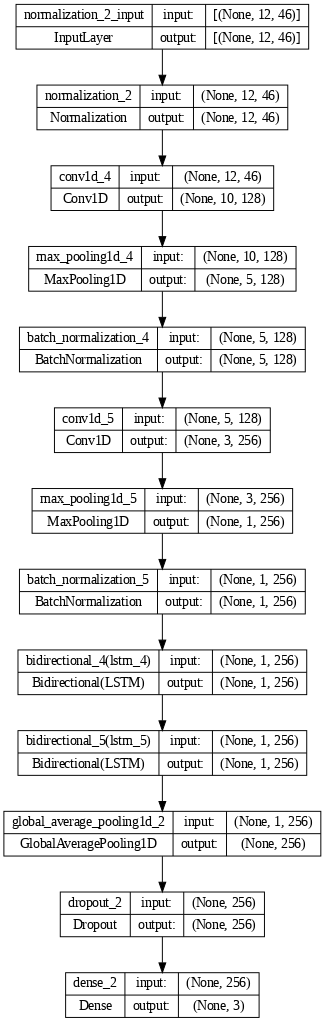

In [ ]:
dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(ai_model.dl_model, to_file=dot_img_file, show_shapes=True, dpi=70)
